In [1]:
import pandas as pd
import  matplotlib.pyplot as plt
import numpy as np

#Loading Data
df = pd.read_table('C:\Users\dcc\Desktop\Tempus/takehome1.txt')     # 530 x 16563
Data = df.values

#Split the Feature data and Ground Truth data
Xdata = Data[:,1:].copy()   # Copyind data to avoid damage to original data
GTdata = Data[:,0].copy() 


In [ ]:
'''
Given the high number of Dimensions(16563), usage of some dimensionality
reduction technique is a must, to remove highly correlated features.
'''

C:\Users\dcc\Anaconda2\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


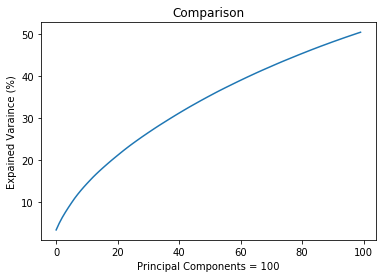

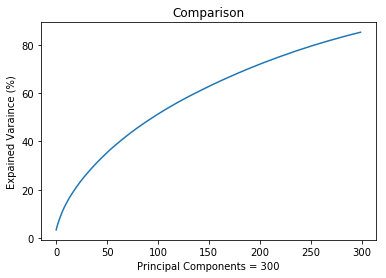

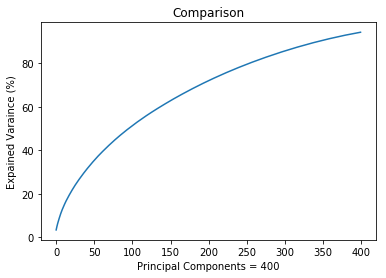

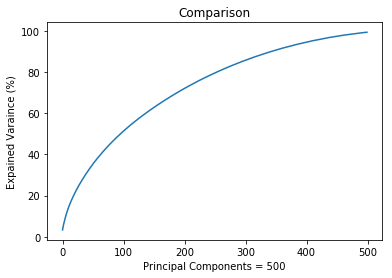

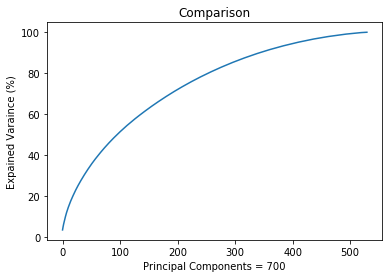

In [2]:
#Checking Proportion of Variance for various value of 
# components in PCA transformed data

from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

Data = scale(Data)           # Normalize data

components = [100, 300, 400,500,700]  #Number of Output Components for PCA 
i=1
for component in components:
    pca = PCA(n_components=component, whiten= True)
    pca.fit(Data)

    #The amount of variance that each PC explains
    var= pca.explained_variance_ratio_

    #Cumulative Variance explains
    var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

    plt.figure(i)
    plt.plot(var1)
    plt.xlabel('Principal Components = %d' % component)
    plt.ylabel('Expained Varaince (%)')
    plt.title('Comparison')
    plt.show()
    i = i+1

In [ ]:
'''
-The above scree plots display the PCA Components needed to explian some percent variance in Data .
-As it is evident from the plots, almost 100% variance in the data is explained
by about 500 PCA components.
-Thus the given 16563 varaibles are highly correlated and we can easily 
reduce the number of dimensions using PCA.
- Almost 98% varaince in data is explained by 400 PCA components.
-To avoid overfitting to the data, i use only 380 PCA components to predict the 
'response' varaible.


'''

In [ ]:
'''
-Given varaible for prediction, 'response' is binary in nature.
Thus, this is a 2-class classification problem.
-After careful observation of data and Ground Truth(GT) values,
it can be easily detected that there is a class imbalance, with 76%
of the GT values being 0.
-To avoid this problem, we divide our data into Training and Test sets
using StratifiedKfold cross validation.
-This method aplits the data, such that the ratio of number of elements of
each class is equal in set of Data. 
-I split the data as follows: Train set - 75%, Test set - 25%
-Further, i divide the Train set data as follows - 
Train_actual = 75% Train set, Validation = 25% Train set.

'''

In [ ]:
'''
-As explained in the case study document, no model is a perfect model.
-So i provide a comparative analysis of 4 well known classification models:
1] Linear SVM, 2] Logistic Regression, 3] Decision tree, 4] Neural Nets.

-As ovserved before, there is a class imbalance in data, with 76% of the GT
values being 0.
-As there is class imbalance in GT values, Accuracy is not the best metric
to judge a classifier.
-With predicting all zeros, a classifier can achieve an accuracy of 76%

-Thus i use F-Measure of the classifer as a metric to judge the best classifier 
for the given data.
        F-Measure = 2*(Precision*Recall)/(Precision+Recall)
-I have displayed the following metrics :
  -Accuracy
  -Precision
  -Recall
  -F-Measure

Finally, i choose the best Classifier based of the F-measure.


'''


In [3]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, KFold

#Importing Classifiers
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

#Importing Classification Metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

names = ["Logistic Regression", "Linear SVM", "Decision Tree", "NNet"]
classifiers = [
                        linear_model.LogisticRegression(C= 0.1),
                        SVC(kernel="linear", C=0.025),
                        DecisionTreeClassifier(max_depth=5),
                        MLPClassifier(alpha=0.9,hidden_layer_sizes=(20,20))

                        ]

best_classifier = {}

for name, classifier in zip(names, classifiers):

#initialize metrics
    best_precision = 0.00
    best_recall = 0.00
    best_Fmeasure = 0.00
    best_accuracy = 0.00
    
# Divide Data into Train and Test sets
    skf = StratifiedKFold(n_splits = 4)
    for Mtrain, test in skf.split(Xdata,GTdata):
        Xtrain = Xdata[Mtrain,:].copy()
        Xtest = Xdata[test,:].copy()
        GTtrain = GTdata[Mtrain]
        GTtest = GTdata[test]


# Divide Train data into Train_actual and Validation
        kf = KFold(n_splits = 4)
        for train, val in kf.split(Xtrain,GTtrain):
                Xtrain_actual = Xtrain[train,:].copy()
                Xval = Xtrain[val,:].copy()
                GTtrain_actual = GTtrain[train]
                GTval = GTtrain[val]

# PCA
                pca = PCA(n_components=380,whiten=True)

# Pipeline Model
                pipe = Pipeline([('pca', pca),
                                 ('classifier', classifier)])
                pipe.fit(Xtrain, GTtrain)
                predicted = pipe.predict(Xtest)
                
# Metrics                
                precision = precision_score(GTtest, predicted)
                if precision > best_precision:  best_precision=precision
                recall = recall_score(GTtest, predicted)
                if recall > best_recall:  best_recall = recall
                accuracy = accuracy_score(GTtest, predicted)
                if accuracy > best_accuracy:  best_accuracy = accuracy
                Fmeasure = f1_score(GTtest, predicted)
                if Fmeasure > best_Fmeasure:  best_Fmeasure = Fmeasure
    best_classifier[best_Fmeasure] = name

    print ("Classifier: " +str(name))
    print ("Accuracy: " + str(round(best_accuracy,3)))
    print("Precision:" + str(round(best_precision,3)) + "\nRecall: " + str(round(best_recall,3)))
    print("F-Measure = " + str(round(best_Fmeasure,3))+"\n")

best = best_classifier.keys()
Label = best_classifier.values()
r = np.arange(1,len(best)+1,1)
best_Fmeasure = max(best)
Fmeasure_of_best = best_classifier.keys()[best_classifier.values().index(best_classifier[best_Fmeasure])]

print("Best Model is: " + str(best_classifier[best_Fmeasure]))
print("Fmeasure: "+ str(round(Fmeasure_of_best,3)))

Classifier: Logistic Regression
Accuracy: 0.887
Precision:0.864
Recall: 0.613
F-Measure = 0.717

Classifier: Linear SVM
Accuracy: 0.88
Precision:0.857
Recall: 0.581
F-Measure = 0.692

Classifier: Decision Tree
Accuracy: 0.805
Precision:0.857
Recall: 0.419
F-Measure = 0.491



C:\Users\dcc\Anaconda2\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Classifier: NNet
Accuracy: 0.895
Precision:1.0
Recall: 0.677
F-Measure = 0.75

Best Model is: NNet
Fmeasure: 0.75


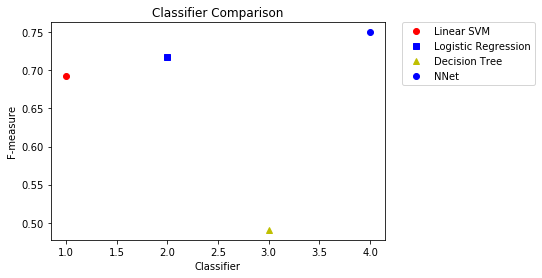

In [4]:
import itertools
marker = itertools.cycle(('ro', 'bs', 'y^', 'bo', 'y*','b^'))
fig, ax = plt.subplots()
for i in range(len(r)):
    ax.plot(r[i], best[i], marker.next(), label=Label[i])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Classifier')
plt.ylabel('F-measure')
plt.title('Classifier Comparison')
plt.show()

In [ ]:
'''
- After careful observation, I had noted that 76% Ground Truth data is 
from class 0.
- So even predicting all zeros will give me an accuracy of 76% in prediction.
- If any model that gives an accuracy less than 76%, is actually harming the 
prediction model.
- Using my machine learning knowledge, i used a few classification models for
prediction. All of them give an Accuracy > 77%.


After observing the above metric based results and F-measure based plot for the 
different models,we can infer the following:


F-Measure based Classifier ranking(1=worst):
4]Neural Net (0.75)
3]Logistic Regression(0717)
2]Linear SVM(0.692)
1]Decision Trees(0.491)

Accuracy based Classifier ranking(1=worst):
4]Neural Net (89.5%)
3]Logistic Regression(88.7%)
2]Linear SVM (88%)
1]Decision Tree(80.5%) 

** All these classifer metrics are naive, and their no hyperparameter tuning has
been done.

Except for Decision trees, all other classifiers have a comparable F-measure.
Thus, for me, the best model would be the one which would give the best
accuracy for a comparable F-measure.
From the above rankings, a model with maximum value after summing the individual ranks
would be the best model.

Here, undisputedly, it is Neural Network.
But if a simpler Model is required, Logistic Regression is a Good bet!

Thus here the best model, Neural Net, has a predicts the data with almost 90% accuracy. 


'''